In [1]:
import pandas as pd
import numpy as np
import sys
import os

import plotly.graph_objects as go
from sklearn.metrics import r2_score

from datetime import datetime, time
sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar, plot_statistical_strip, plot_scatter, plot_distribution
from core.s3 import S3AssetManager

In [2]:
notebook_name = "okuo_sensores_ph_orp_granja_experimental"
s3 = S3AssetManager(notebook_name=notebook_name)

In [3]:

# 2. Definimos la función de categorización
def clasificar_franja_horaria(fecha):
    hora = fecha.hour
    
    # Rango 1: 6:00 AM hasta las 9:59 AM (incluye hora 9)
    if 6 <= hora < 10:
        return "06:00 AM - 10:00 AM"
    
    # Rango 2: 10:00 AM hasta las 11:59 AM
    elif 10 <= hora < 12:
        return "10:00 AM - 12:00 PM"
    
    # Rango 3: 12:00 PM hasta las 2:59 PM (14:59)
    elif 12 <= hora < 15:
        return "12:00 PM - 03:00 PM"
    
    # Todo lo demás (madrugada, tarde-noche)
    else:
        return "Resto del día"



In [4]:
df = pd.read_excel("../raw/SEGUIMIENTO ORP GRANJA EXPERIMENTAL.xlsx",
)
df.columns = df.columns.str.strip().str.lower()

In [22]:
cls = [
'ph granja', 'orp granja', 'ph telemetría',
'orp telemetría', 'diferencia ph', 'diferencia orp'
]

for cl in cls:
    df[cl] = pd.to_numeric(df[cl], errors='coerce')

df['date'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(str))
df

,fecha,hora,ph granja,orp granja,ph telemetría,orp telemetría,diferencia ph,diferencia orp,date
0,2025-11-14,09:23:00,4.95,801,4.85,857,-0.10,56,2025-11-14 09:23:00
1,2025-11-14,13:59:00,5.80,751,5.62,832,-0.18,81,2025-11-14 13:59:00
2,2025-11-15,10:00:00,5.80,773,5.93,808,0.13,35,2025-11-15 10:00:00
3,2025-11-15,14:49:00,6.05,711,6.43,780,0.38,69,2025-11-15 14:49:00
4,2025-11-17,06:55:00,5.99,640,NaN,779,NaN,139,2025-11-17 06:55:00
5,2025-11-17,10:55:00,6.38,680,NaN,756,NaN,76,2025-11-17 10:55:00
6,2025-11-18,10:13:00,6.20,614,6.69,718,0.49,104,2025-11-18 10:13:00
7,2025-11-21,14:30:00,4.88,606,3.72,712,-1.16,106,2025-11-21 14:30:00
8,2025-11-22,14:58:00,6.35,638,6.42,742,0.07,104,2025-11-22 14:58:00
9,2025-11-24,10:16:00,7.05,633,7.06,750,0.01,117,2025-11-24 10:16:00


In [34]:

df_granja = df[['date', 'ph granja', 'orp granja']].copy()
df_granja.columns = ['date', 'ph', 'orp']
df_granja['categoria'] = 'Granja'

df_telemetria = df[['date', 'ph telemetría', 'orp telemetría']].copy()
df_telemetria.columns = ['date', 'ph', 'orp']
df_telemetria['categoria'] = 'Telemetría'

df_transformado = pd.concat([df_granja, df_telemetria], ignore_index=True)
df_transformado = df_transformado.sort_values(by='date').reset_index(drop=True)


df_transformado['franja_horaria'] = df_transformado['date'].apply(clasificar_franja_horaria)

bins = [-np.inf, 3, 4, 5, 6, 7, np.inf]

# 2. Etiquetas simplificadas
labels = [
    '< 3',
    '3 - 4',
    '4 - 5',
    '5 - 6',
    '6 - 7',
    '> 7'  # Agregado por seguridad para tus valores de 7.05, 7.20, etc.
]

# 3. Aplicar la categorización
# right=False: El intervalo '3 - 4' incluye el 3.0 pero excluye el 4.0 exacto
df_transformado['rango_ph'] = pd.cut(
    df_transformado['ph'], 
    bins=bins, 
    labels=labels, 
    right=False
)


# 1. Definir los cortes para ORP (de 50 en 50 según tus datos)
# Capturamos desde valores bajos (<600) hasta valores altos (>850)
bins_orp = [-np.inf, 600, 650, 700, 750, 800, 850, np.inf]

# 2. Etiquetas
labels_orp = [
    '< 600',
    '600 - 650',
    '650 - 700',
    '700 - 750',
    '750 - 800',
    '800 - 850',
    '> 850'
]

# 3. Aplicar la categorización
df_transformado['rango_orp'] = pd.cut(
    df_transformado['orp'], 
    bins=bins_orp, 
    labels=labels_orp, 
    right=False
)


df_transformado

,date,ph,orp,categoria,franja_horaria,rango_ph,rango_orp
0,2025-11-14 09:23:00,4.95,801,Granja,06:00 AM - 10:00 AM,4 - 5,800 - 850
1,2025-11-14 09:23:00,4.85,857,Telemetría,06:00 AM - 10:00 AM,4 - 5,> 850
2,2025-11-14 13:59:00,5.80,751,Granja,12:00 PM - 03:00 PM,5 - 6,750 - 800
3,2025-11-14 13:59:00,5.62,832,Telemetría,12:00 PM - 03:00 PM,5 - 6,800 - 850
4,2025-11-15 10:00:00,5.80,773,Granja,10:00 AM - 12:00 PM,5 - 6,750 - 800
5,2025-11-15 10:00:00,5.93,808,Telemetría,10:00 AM - 12:00 PM,5 - 6,800 - 850
6,2025-11-15 14:49:00,6.05,711,Granja,12:00 PM - 03:00 PM,6 - 7,700 - 750
7,2025-11-15 14:49:00,6.43,780,Telemetría,12:00 PM - 03:00 PM,6 - 7,750 - 800
8,2025-11-17 06:55:00,5.99,640,Granja,06:00 AM - 10:00 AM,5 - 6,600 - 650
9,2025-11-17 06:55:00,NaN,779,Telemetría,06:00 AM - 10:00 AM,NaN,750 - 800


In [35]:
by_moment = df_transformado.groupby(['franja_horaria', 'categoria']).agg(
    ph=('ph', 'median'),
    orp=('orp', 'median'),
    measurements=('date', 'count')
).reset_index()
by_moment

,franja_horaria,categoria,ph,orp,measurements
0,06:00 AM - 10:00 AM,Granja,5.480,677.5,4
1,06:00 AM - 10:00 AM,Telemetría,4.850,818.0,4
2,10:00 AM - 12:00 PM,Granja,5.800,747.0,7
3,10:00 AM - 12:00 PM,Telemetría,4.930,808.0,7
4,12:00 PM - 03:00 PM,Granja,5.870,713.0,10
5,12:00 PM - 03:00 PM,Telemetría,5.875,800.0,10


In [61]:
by_delta = df_transformado.groupby(['rango_ph', 'categoria']).agg(
    ph=('ph', 'median'),
    orp=('orp', 'median'),
    measurements=('date', 'count')
).reset_index()
by_delta["rango_ph"].unique()

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_20759/3471641392.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



['< 3', '3 - 4', '4 - 5', '5 - 6', '6 - 7', '> 7']
Categories (6, object): ['< 3' < '3 - 4' < '4 - 5' < '5 - 6' < '6 - 7' < '> 7']

In [38]:
by_delta_orp = df_transformado.groupby(['rango_orp', 'categoria']).agg(
    ph=('ph', 'median'),
    orp=('orp', 'median'),
    measurements=('date', 'count')
).reset_index()
by_delta_orp

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_20759/39301507.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,rango_orp,categoria,ph,orp,measurements
0,< 600,Granja,6.990,598.0,1
1,< 600,Telemetría,NaN,NaN,0
2,600 - 650,Granja,6.350,614.0,7
3,600 - 650,Telemetría,NaN,NaN,0
4,650 - 700,Granja,6.380,680.0,1
5,650 - 700,Telemetría,NaN,NaN,0
6,700 - 750,Granja,4.935,715.0,4
7,700 - 750,Telemetría,6.555,726.0,4
8,750 - 800,Granja,5.800,773.0,5
9,750 - 800,Telemetría,7.050,755.5,6


In [62]:
f_ph_rango = plot_bar(
    df=by_delta,
    x_col='rango_ph',
    y_col='ph',
    group_col='categoria',
    cat_base='Telemetría',
    show_delta=True,
    hover_data_cols=['orp', 'measurements'],
     order_x=['< 3', '3 - 4', '4 - 5', '5 - 6', '6 - 7', '> 7'],
    text_format='.2f',
    x_title='Rango de pH',
    y_title='pH',
    

)
f_ph_rango.show()
s3.save_plotly_html(f_ph_rango, 'by_rango_ph.html')

In [63]:
plot_bar

<function core.viz.plot_bar(df: pandas.core.frame.DataFrame, x_col: str, y_col: str, group_col: Optional[str] = None, order_x: Optional[List[str]] = None, order_groups: Optional[List[str]] = None, cat_base: Optional[str] = None, filter_empty: bool = True, compact_mode: bool = False, cluster_width: float = 0.8, bar_width_scale: float = 0.9, barmode: str = 'group', show_delta: bool = False, delta_reference_group: Optional[str] = None, delta_unit: str = '', hover_data_cols: Optional[List[str]] = None, title: str = '', x_title: Optional[str] = None, y_title: Optional[str] = None, text_format: str = '.1f', bar_colors: Union[List[str], Dict[str, str], NoneType] = None, height: int = 500, width: int = 1000, font_family: str = 'Inter, Arial, sans-serif', output_path: Optional[str] = None) -> plotly.graph_objs._figure.Figure>

In [64]:
f_orp_rango = plot_bar(
    df=by_delta_orp,
    x_col='rango_orp',
    y_col='orp',
    group_col='categoria',
    cat_base='Telemetría',
    show_delta=True,
    hover_data_cols=['orp', 'measurements'],
    text_format='.2f',
    x_title='Rango Orp',
    y_title='pH',
    order_x=['< 600', '600 - 650', '650 - 700', '700 - 750', '750 - 800', '800 - 850', '> 850']
    
    

)
f_orp_rango.show()
s3.save_plotly_html(f_orp_rango, 'by_rango_orp.html')

In [ ]:
f_ph = plot_bar(
    df=by_moment,
    x_col='franja_horaria',
    y_col='ph',
    group_col='categoria',
    cat_base='Telemetría',
    show_delta=True,
    hover_data_cols=['orp', 'measurements'],
    text_format='.2f',
    x_title='Francia horaria',
    y_title='pH',
    

)
f_ph.show()
s3.save_plotly_html(f_ph, 'by_moment_ph.html')

In [10]:
f_orp = plot_bar(
    df=by_moment,
    x_col='franja_horaria',
    y_col='orp',
    group_col='categoria',
    cat_base='Telemetría',
    show_delta=True,
    hover_data_cols=['ph', 'measurements'],
    text_format='.2f',
    x_title='Francia horaria',
    y_title='ORP',
    

)
f_orp.show()
s3.save_plotly_html(f_orp, 'by_moment_orp.html')

In [11]:
create_subplot_grid

<function core.viz.create_subplot_grid(figures: List[plotly.graph_objs._figure.Figure], rows: int, cols: int, titles: Optional[List[str]] = None, shared_x: bool = False, shared_y: bool = False, main_title: str = '', height: int = 800, width: int = 1000, output_path: Optional[str] = None) -> plotly.graph_objs._figure.Figure>

In [12]:
f_complete = create_subplot_grid(
    figures=[f_ph, f_orp], rows=1, cols=2, 
    titles=['pH', 'ORP'], shared_x=True, shared_y=False,
     main_title='Comportamiento de pH y ORP a lo largo del día (Tomando como referencia mediciones con Telemetría)', width=1200, height=400)
f_complete.show()
s3.save_plotly_html(f_complete, 'by_moment_ph_orp.html')

In [13]:
time_ph = plot_scatter(
    df=df_transformado,
    x_col="date",
    y_col="ph",
    group_col="categoria",
    x_title="Fecha",
    y_title="pH",
    title="pH vs Fecha",
    width=800,
    height=400
)
time_ph.show()
s3.save_plotly_html(time_ph, 'time_ph.html')


In [14]:
time_orp = plot_scatter(
    df=df_transformado,
    x_col="date",
    y_col="orp",
    group_col="categoria",
    x_title="Fecha",
    y_title="ORP",
    title="ORP vs Fecha",
       width=800,
    height=400
)
time_orp.show()
s3.save_plotly_html(time_orp, 'time_orp.html')

In [15]:
f_time_ph_orp = create_subplot_grid(
    figures=[time_ph, time_orp],
    rows=1,
    cols=2,
    titles=['pH', 'ORP'], shared_x=True, shared_y=False,
    main_title='Comportamiento de pH y ORP a lo largo en el tiempo', width=1200, height=400)

f_time_ph_orp.show()
s3.save_plotly_html(f_time_ph_orp, 'time_ph_orp.html')


In [16]:
plot_scatter(
    df=df_transformado,
    x_col="ph",
    y_col="orp",
    group_col="categoria",
    x_title="pH",
    y_title="ORP",
    title="pH vs ORP",
    width=800,
    height=400,
)

In [17]:


def plot_ph_orp_regressions_complete(
    df: pd.DataFrame,
    title: str = "Correlación pH vs ORP: Ecuaciones y Ajuste",
    width: int = 1000,
    height: int = 600
):
    fig = go.Figure()
    
    colors = {'Granja': '#1C8074', 'Telemetría': '#666666'}
    
    for cat in df['categoria'].unique():
        d_cat = df[df['categoria'] == cat].dropna(subset=['ph', 'orp'])
        if len(d_cat) < 2: continue 
        
        x = d_cat['ph'].values
        y = d_cat['orp'].values
        color = colors.get(cat, 'grey')

        # --- A. PUNTOS REALES ---
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='markers', 
            name=f'{cat} (Datos)', # Nombre simple para los puntos
            marker=dict(color=color, size=9, opacity=0.7, line=dict(width=1, color='black'))
        ))

        # Generar rango para las líneas
        x_range = np.linspace(x.min(), x.max(), 100)

        # --- B. REGRESIÓN LINEAL (y = mx + b) ---
        coef_lin = np.polyfit(x, y, 1) # [m, b]
        m, b = coef_lin
        poly1 = np.poly1d(coef_lin)
        r2_lin = r2_score(y, poly1(x))
        
        # Formateo inteligente de la ecuación (manejo de signos)
        sign_b = "+" if b >= 0 else "-"
        eq_label_lin = f"y={m:.1f}x {sign_b} {abs(b):.0f}"
        
        fig.add_trace(go.Scatter(
            x=x_range, y=poly1(x_range), mode='lines',
            # AQUÍ ESTÁ LA CLAVE: Ecuación + R2 en la leyenda
            name=f'{cat} Lin: {eq_label_lin} (R²={r2_lin:.2f})',
            line=dict(color=color, width=3, dash='solid'),
            hovertemplate=f"<b>{cat} Lineal</b><br>pH: %{{x:.2f}}<br>ORP: %{{y:.0f}}<br>Ecuación: {eq_label_lin}"
        ))

        # --- C. REGRESIÓN POLINÓMICA (y = ax² + bx + c) ---
        if len(d_cat) > 3:
            coef_poly = np.polyfit(x, y, 2) # [a, b, c]
            a, b_poly, c_poly = coef_poly
            poly2 = np.poly1d(coef_poly)
            r2_poly = r2_score(y, poly2(x))

            # Formateo de la ecuación cuadrática
            sign_b_poly = "+" if b_poly >= 0 else "-"
            sign_c_poly = "+" if c_poly >= 0 else "-"
            eq_label_poly = f"y={a:.1f}x² {sign_b_poly} {abs(b_poly):.1f}x {sign_c_poly} {abs(c_poly):.0f}"

            fig.add_trace(go.Scatter(
                x=x_range, y=poly2(x_range), mode='lines',
                name=f'{cat} Poly: {eq_label_poly} (R²={r2_poly:.2f})',
                line=dict(color=color, width=3, dash='dot'),
                visible='legendonly' # Oculto por defecto para no saturar
            ))

    # --- ESTILOS Y MARGENES ---
    fig.update_layout(
        title={'text': f"<b>{title}</b>", 'y': 0.98, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
        font=dict(family="Inter, Arial, sans-serif", size=12, color="black"),
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        
        # Margen superior amplio (150) para que quepan las leyendas largas
        margin=dict(l=60, r=40, t=150, b=60),
        
        legend=dict(
            orientation="h", 
            yanchor="bottom", 
            y=1.02, 
            xanchor="center", 
            x=0.5,
            # Forzamos que la leyenda se ajuste si es muy ancha
            entrywidth=0, 
            entrywidthmode="pixels"
        ),
        
        height=height,
        width=width,
        hovermode="x unified"
    )
    
    axis_style = dict(
        showline=True, linecolor="black", linewidth=2,        
        ticks="outside", tickcolor="black", tickfont=dict(color="black"),
        showgrid=True, gridcolor='rgba(0,0,0,0.1)' 
    )

    fig.update_xaxes(
        **axis_style,
        title=dict(text="pH", font=dict(color="black", size=14), standoff=15)
    )
    
    fig.update_yaxes(
        **axis_style,
        zeroline=False,
        title=dict(text="ORP (mV)", font=dict(color="black", size=14), standoff=15)
    )
    
    return fig


In [18]:
fig = plot_ph_orp_regressions_complete(df_transformado)
fig.show()
s3.save_plotly_html(fig, 'ph_orp_relacion.html')


In [19]:
ph_sensors = pd.read_csv("../raw/granja_exp__variable_p2__.csv")

In [21]:
ph_sensors["date"].min(), ph_sensors["date"].max()

('2025-11-01 00:00:04-05:00', '2025-12-31 23:58:50-05:00')

In [21]:
ph_sensors = ph_sensors[ph_sensors['value'].between(0, 14)]

In [22]:
#plot_line(ph_sensors, x_col="date", y_col="value", title="PH")

In [23]:
ph_sensors.head()

,date,createdAt,timestamp,context,value
0,2025-12-31 23:58:50-05:00,1767243550560,1767243530000,{},6.78
1,2025-12-31 23:58:37-05:00,1767243538257,1767243517000,{},6.78
2,2025-12-31 23:58:24-05:00,1767243518443,1767243504000,{},6.78
3,2025-12-31 23:58:11-05:00,1767243518443,1767243491000,{},6.78
4,2025-12-31 23:58:08-05:00,1767243507094,1767243488000,{},6.78


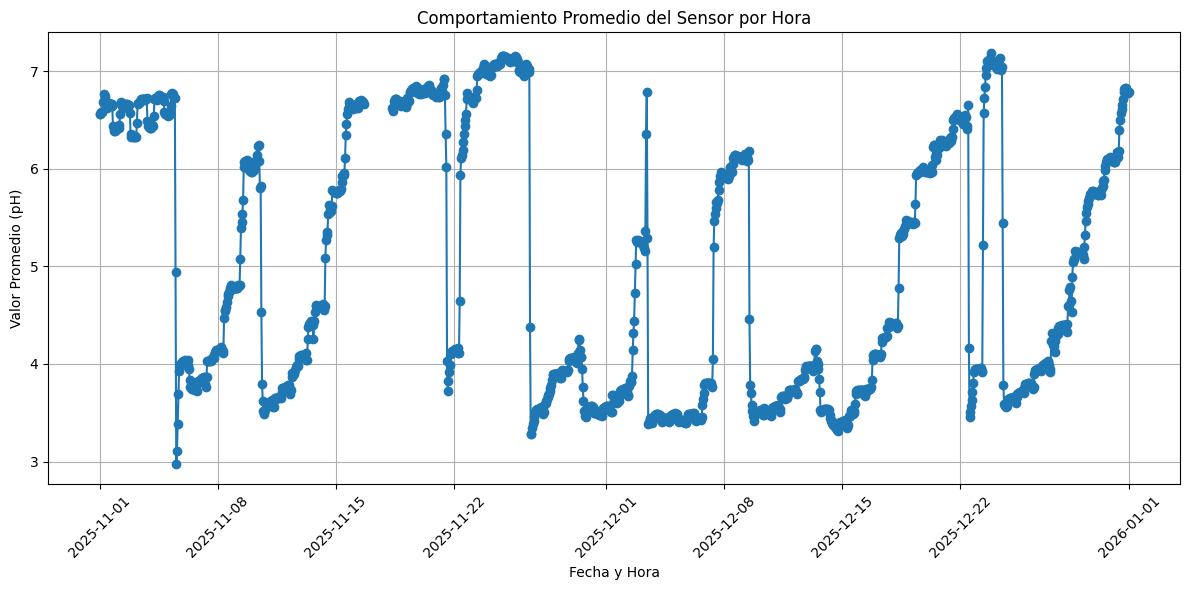

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Asegurar que 'date' sea datetime (Pandas maneja el -05:00 automático)
# ✅ CORRECTO
ph_sensors['date'] = pd.to_datetime(ph_sensors['date'])

# 2. Para usar resample, la fecha debe ser el Índice del DataFrame
df = ph_sensors.set_index('date')

# 3. Agrupar por Hora ('h') y calcular el promedio (mean)
# Puedes cambiar .mean() por .max(), .min() o .last() según lo que quieras ver
df_horario = df['value'].resample('h').mean()

# --- Opcional: Si quieres mantener el DataFrame con columnas ---
# df_horario = df_horario.reset_index()

# 4. Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_horario.index, df_horario.values, marker='o', linestyle='-')
plt.title('Comportamiento Promedio del Sensor por Hora')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor Promedio (pH)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

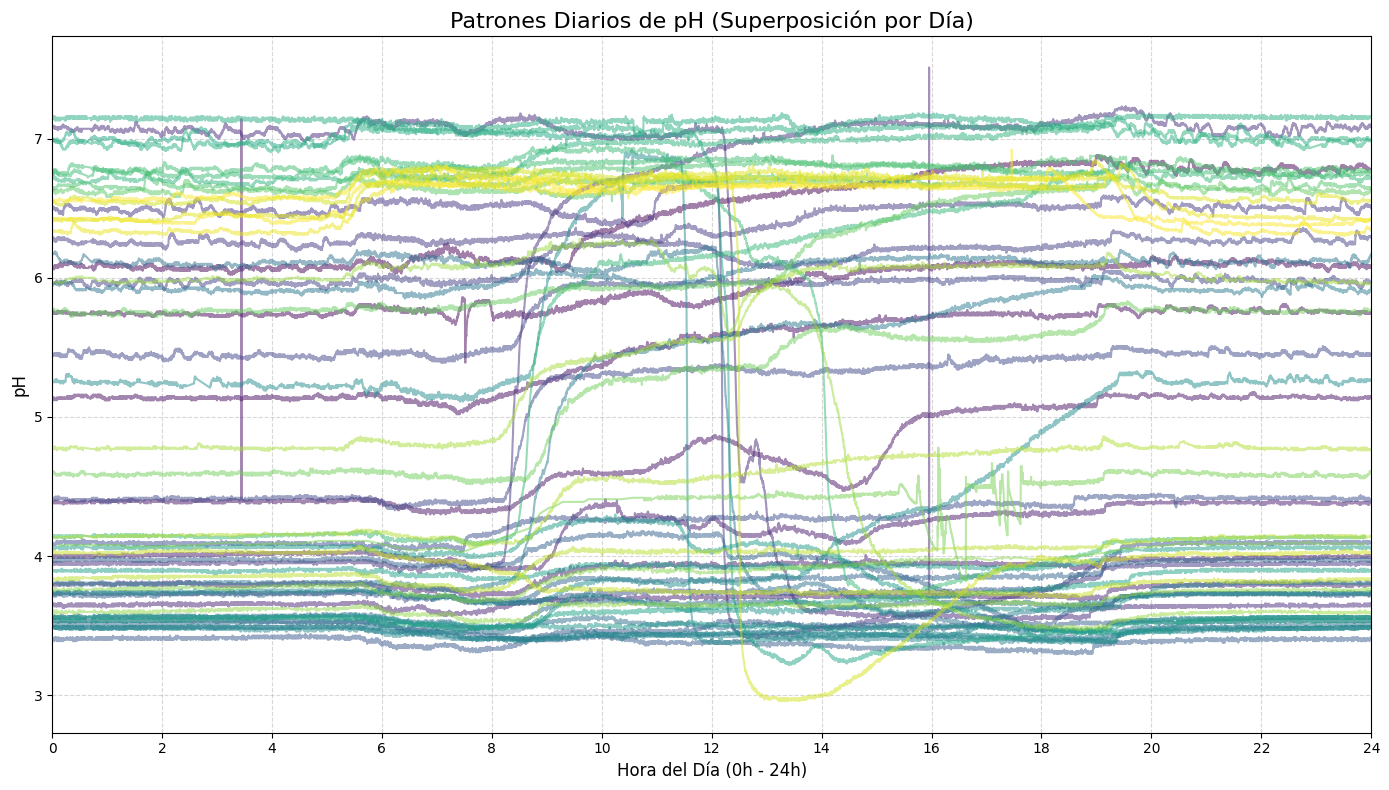

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df =ph_sensors.copy()

# 1. Asegúrate de que 'date' es datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Crear las columnas necesarias para los ejes
# Eje X: Hora decimal (ej: 14:30 -> 14.5) para que la curva sea suave y continua
df['hora_decimal'] = df['date'].dt.hour + df['date'].dt.minute/60 + df['date'].dt.second/3600

# Agrupador: Fecha sola (sin hora) para separar cada curva
df['fecha_solo'] = df['date'].dt.date

# 3. Graficar
plt.figure(figsize=(14, 8))

# Obtener los días únicos para iterar
dias = df['fecha_solo'].unique()

# Usar una paleta de colores gradual para ver la evolución en el tiempo (opcional)
colores = plt.cm.viridis(np.linspace(0, 1, len(dias)))

for i, dia in enumerate(dias):
    # Filtrar datos de ese día específico
    datos_dia = df[df['fecha_solo'] == dia]
    
    # Graficar: X=Hora Decimal, Y=Valor
    # alpha=0.6 hace las líneas semitransparentes para ver mejor la densidad
    plt.plot(datos_dia['hora_decimal'], datos_dia['value'], 
             label=str(dia), color=colores[i], alpha=0.5, linewidth=1.5)

# 4. Formato del gráfico
plt.title('Patrones Diarios de pH (Superposición por Día)', fontsize=16)
plt.xlabel('Hora del Día (0h - 24h)', fontsize=12)
plt.ylabel('pH', fontsize=12)
plt.xticks(np.arange(0, 25, 2)) # Marcas en el eje X cada 2 horas
plt.xlim(0, 24) # Asegurar que el eje vaya de 0 a 24
plt.grid(True, linestyle='--', alpha=0.5)

# Opcional: Mostrar leyenda solo si son pocos días, si son muchos mejor quitarla
if len(dias) < 15:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fecha")

plt.tight_layout()
plt.show()

In [26]:
import skfda
from skfda.exploratory.visualization import Boxplot, MagnitudeShapePlot
from skfda.preprocessing.dim_reduction import FPCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


✅ Matriz creada con éxito. Dimensiones: (60, 288)


<Figure size 1000x600 with 0 Axes>

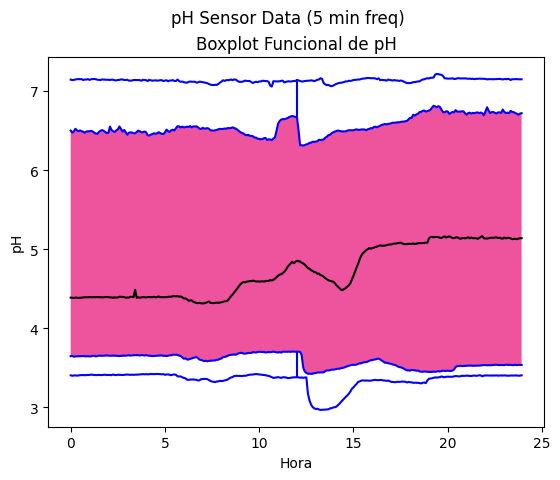

<Figure size 1000x600 with 0 Axes>

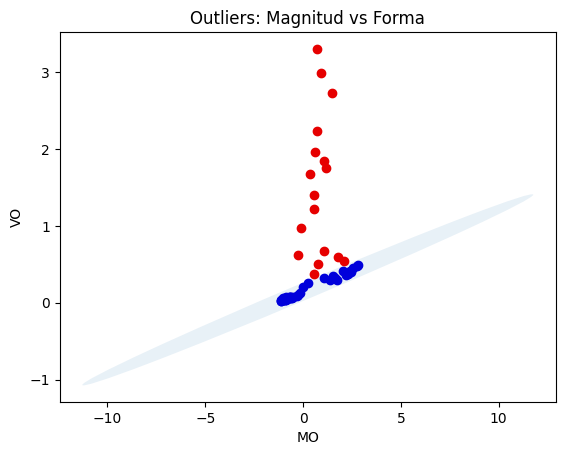

<Figure size 1000x600 with 0 Axes>

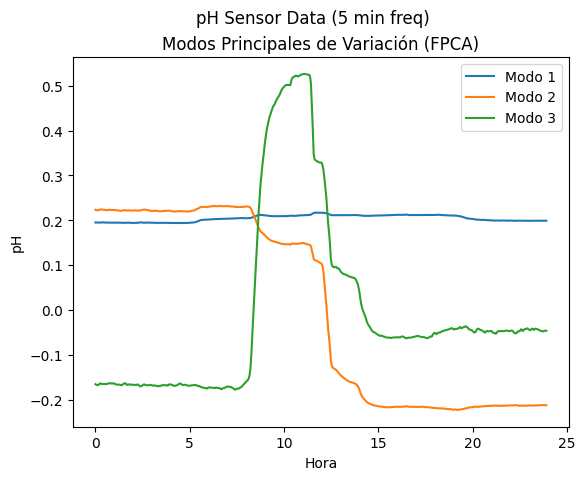

Varianza explicada por componentes: [0.79303994 0.18555322 0.01019609]


In [27]:


# ==========================================
# 1. PREPARACIÓN SEGURA (Evita crash de RAM)
# ==========================================

# Asegurar datetime
df['date'] = pd.to_datetime(df['date'])

# PASO CRÍTICO: Redondear/Agrupar tiempos a una grilla común (ej. cada 5 min)
# Esto alinea todos los días para que compartan las mismas columnas
df_resampled = (df.set_index('date')
                  .resample('5min')['value']  # Agrupar cada 5 minutos
                  .mean()                     # Promediar valores en ese lapso
                  .reset_index())

# Ahora creamos las columnas de eje para la matriz
df_resampled['fecha_solo'] = df_resampled['date'].dt.date
# Hora decimal exacta basada en el intervalo de 5 min (0.0, 0.083, 0.16...)
df_resampled['hora_decimal'] = df_resampled['date'].dt.hour + df_resampled['date'].dt.minute/60

# Pivotar: Ahora la matriz será pequeña y manejable (aprox 288 columnas por día)
datos_matriz = df_resampled.pivot(index='fecha_solo', columns='hora_decimal', values='value')

# Limpieza de huecos (ahora sí es seguro)
# 1. Interpolación lineal para huecos pequeños
datos_matriz = datos_matriz.interpolate(axis=1)
# 2. Rellenar bordes (inicio/fin de día)
datos_matriz = datos_matriz.bfill(axis=1).ffill(axis=1)
# 3. Eliminar días que quedaron vacíos (si hubo apagón de sensor todo el día)
datos_matriz = datos_matriz.dropna()

print(f"✅ Matriz creada con éxito. Dimensiones: {datos_matriz.shape}")
# Debería decir algo como (Num_Dias, 288). Si dice (Num_Dias, 50000) algo salió mal.

# ==========================================
# 2. CREACIÓN DEL OBJETO FUNCIONAL
# ==========================================

fd = skfda.FDataGrid(
    data_matrix=datos_matriz.values,
    grid_points=datos_matriz.columns.values,
    dataset_name='pH Sensor Data (5 min freq)',
    argument_names=['Hora'],
    coordinate_names=['pH']
)

# ==========================================
# 3. ANÁLISIS (Ahora correrá rápido)
# ==========================================

# A. Boxplot (Outliers)
plt.figure(figsize=(10, 6))
fig1 = Boxplot(fd, depth_method=skfda.exploratory.depth.ModifiedBandDepth())
fig1.plot()
plt.title("Boxplot Funcional de pH")
plt.show()

# B. Magnitude-Shape Plot (Detectar anomalías de forma)
plt.figure(figsize=(10, 6))
# El MS-Plot puede ser sensible, envolvemos en try/except por si acaso
try:
    fig2 = MagnitudeShapePlot(fd)
    fig2.plot()
    plt.title("Outliers: Magnitud vs Forma")
    plt.show()
except Exception as e:
    print(f"No se pudo generar MS-Plot: {e}")

# C. FPCA (Componentes Principales)
fpca = FPCA(n_components=3)
fpca.fit(fd)
plt.figure(figsize=(10, 6))
fpca.components_.plot()
plt.title("Modos Principales de Variación (FPCA)")
plt.legend(['Modo 1', 'Modo 2', 'Modo 3'])
plt.show()

print(f"Varianza explicada por componentes: {fpca.explained_variance_ratio_}")

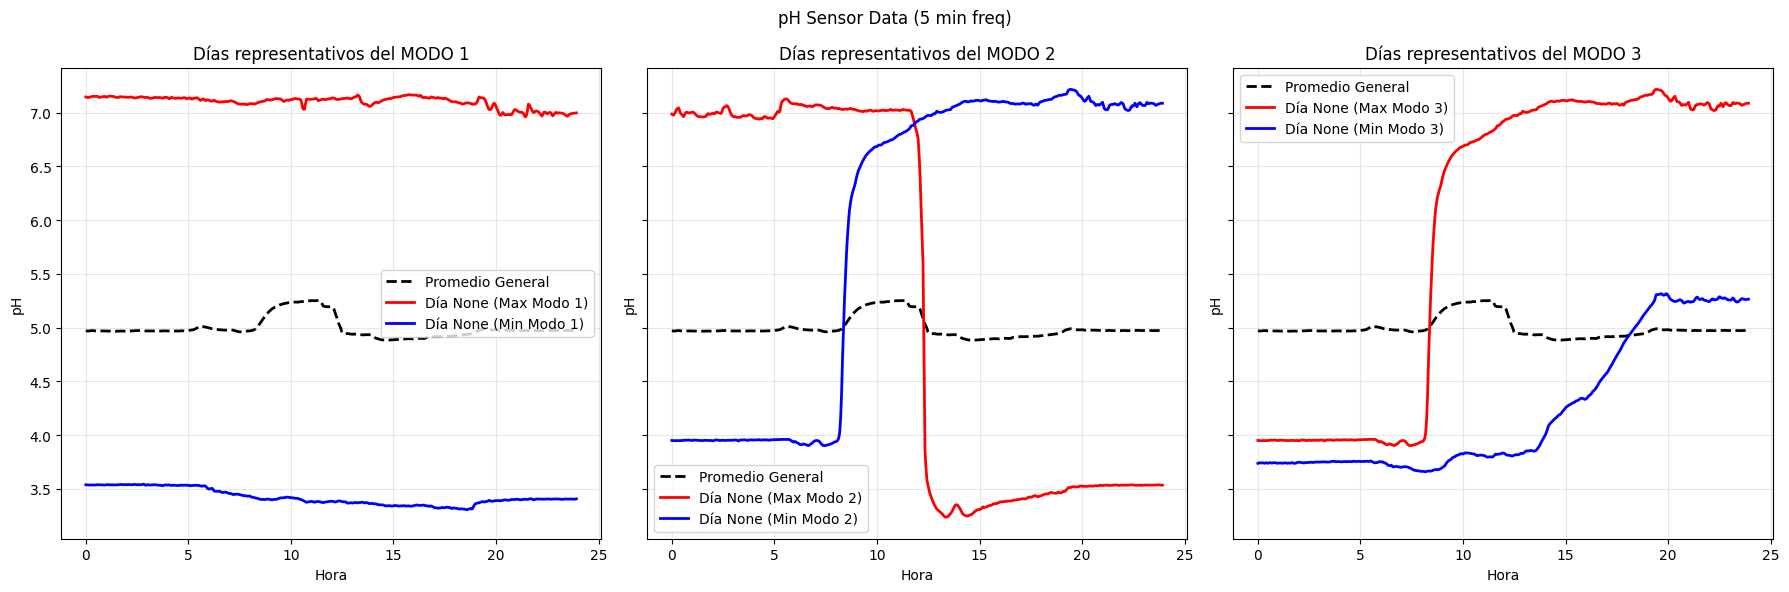

Identificación de fechas críticas:
Modo 1:
   (+) Sigue el patrón fuertemente: None
   (-) Opuesto al patrón:           None
Modo 2:
   (+) Sigue el patrón fuertemente: None
   (-) Opuesto al patrón:           None
Modo 3:
   (+) Sigue el patrón fuertemente: None
   (-) Opuesto al patrón:           None


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Obtener los scores (Coordenadas de cada día en cada modo)
# Esto devuelve una matriz de tamaño [n_dias, n_componentes]
scores = fpca.transform(fd)

# 2. Preparar la figura con 3 subplots (uno por modo)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
modos = [0, 1, 2] # Modo 1, 2 y 3 (índices 0, 1, 2)

# La curva media (el comportamiento base)
media_fd = fpca.mean_

for i, ax in zip(modos, axes):
    # --- A. Encontrar los días extremos ---
    # Día con mayor score positivo (se parece más al patrón sumado)
    idx_max = np.argmax(scores[:, i])
    # Día con mayor score negativo (se parece más al patrón restado)
    idx_min = np.argmin(scores[:, i])

    # --- B. Graficar ---
    # 1. Graficar la media en negro (referencia)
    media_fd.plot(ax, color='black', linestyle='--', linewidth=2, label='Promedio General')

    # 2. Graficar el día con comportamiento (+) del Modo
    # Accedemos al día específico usando fd[indice]
    fd[idx_max].plot(ax, color='red', linewidth=2, label=f'Día {fd.sample_names[idx_max]} (Max Modo {i+1})')

    # 3. Graficar el día con comportamiento (-) del Modo
    fd[idx_min].plot(ax, color='blue', linewidth=2, label=f'Día {fd.sample_names[idx_min]} (Min Modo {i+1})')

    # Decoración
    ax.set_title(f'Días representativos del MODO {i+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- C. Imprimir las fechas exactas ---
print("Identificación de fechas críticas:")
for i in modos:
    idx_max = np.argmax(scores[:, i])
    idx_min = np.argmin(scores[:, i])
    print(f"Modo {i+1}:")
    print(f"   (+) Sigue el patrón fuertemente: {fd.sample_names[idx_max]}")
    print(f"   (-) Opuesto al patrón:           {fd.sample_names[idx_min]}")

Tabla de Scores (Primeros 5 días):
            Score_Modo_1  Score_Modo_2  Score_Modo_3
fecha_solo                                          
2025-11-01      7.833842      0.145533     -0.517302
2025-11-02      7.591920     -0.065458     -0.326683
2025-11-03      7.732110     -0.363571     -0.186110
2025-11-04      8.007498     -0.313275     -0.272743
2025-11-05      1.140591      6.783231      0.476968


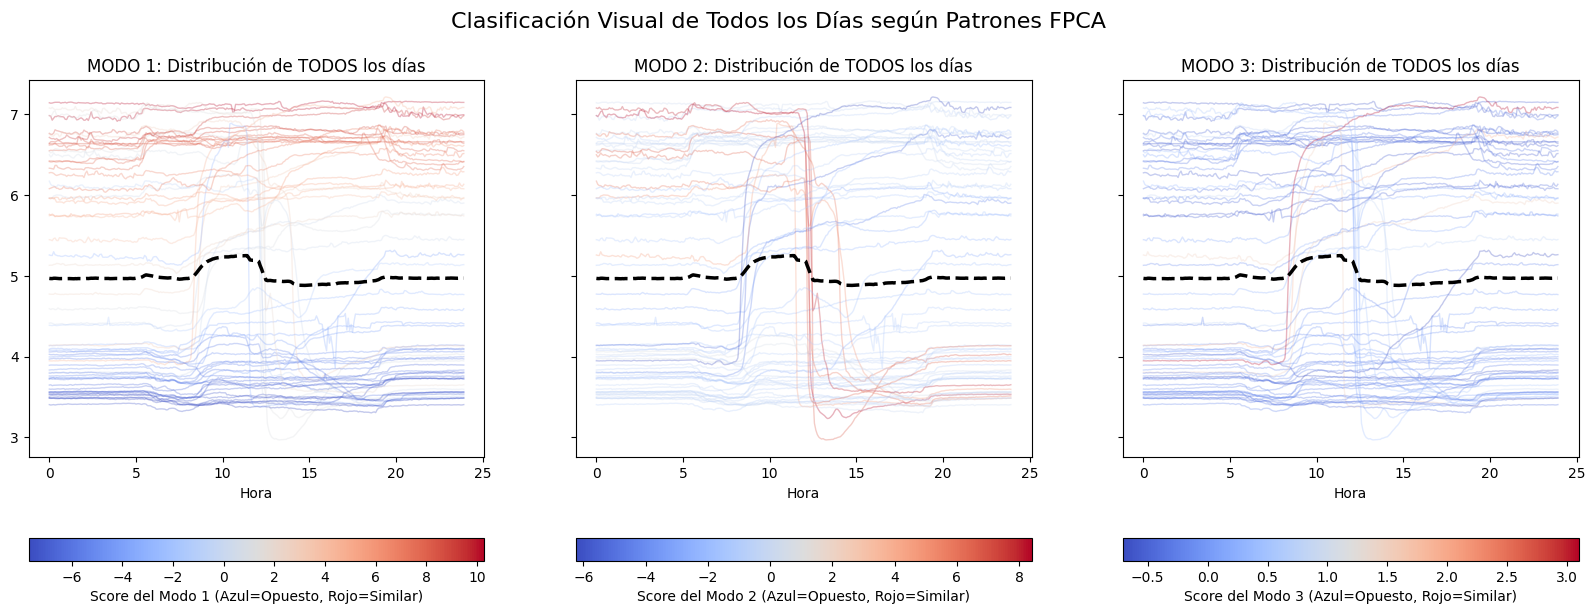

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# 1. CORRECCIÓN IMPORTANTE: Asignar las fechas al objeto funcional
# Asumiendo que 'datos_matriz' tiene las fechas en su índice
fd.sample_names = [str(fecha) for fecha in datos_matriz.index]

# 2. Obtener los scores de TODOS los días
scores = fpca.transform(fd)

# 3. Crear un DataFrame para ver los datos numéricos (ENCONTRAR)
df_scores = pd.DataFrame(
    scores,
    index=datos_matriz.index,
    columns=['Score_Modo_1', 'Score_Modo_2', 'Score_Modo_3']
)

# Ordenamos por fecha o por score si quisieras
print("Tabla de Scores (Primeros 5 días):")
print(df_scores.head()) 
# Tip: Puedes exportar esto: df_scores.to_excel("analisis_modos.xlsx")

# 4. GRAFICAR TODOS LOS DÍAS CON COLOR (VISUALIZAR)
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
modos = [0, 1, 2]

# Obtenemos la media para graficarla como referencia
media_y = fpca.mean_.data_matrix[0, ..., 0]
grid_x = fpca.mean_.grid_points[0]

for i, ax in zip(modos, axes):
    # A. Configurar mapa de colores para este modo
    # Los días con score alto serán Rojos, bajos serán Azules
    valores_score = scores[:, i]
    norm = mcolors.Normalize(vmin=valores_score.min(), vmax=valores_score.max())
    cmap = cm.coolwarm # Azul-Blanco-Rojo

    # B. Graficar CADA día
    # Iteramos sobre cada curva y la pintamos según su score
    for idx in range(fd.n_samples):
        # Extraer datos Y de la curva
        y = fd.data_matrix[idx, ..., 0]
        # Obtener color basado en el score
        color = cmap(norm(valores_score[idx]))
        # Graficar con transparencia (alpha) para ver la densidad
        ax.plot(grid_x, y, color=color, alpha=0.3, linewidth=1)

    # C. Graficar la media (referencia) en Negro grueso
    ax.plot(grid_x, media_y, color='black', linestyle='--', linewidth=2.5, label='Promedio')

    # Decoración
    ax.set_title(f'MODO {i+1}: Distribución de TODOS los días', fontsize=12)
    ax.set_xlabel("Hora")
    
    # Añadir barra de color pequeña para entender la escala
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15)
    cbar.set_label(f'Score del Modo {i+1} (Azul=Opuesto, Rojo=Similar)')

plt.suptitle("Clasificación Visual de Todos los Días según Patrones FPCA", fontsize=16)
plt.show()

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PREPARACIÓN DE DATOS
# ==============================================================================
# A. Datos para Gráfica de Líneas (Perturbaciones)
# Nota: fpca.components_ contiene solo las formas de variación (sin la media)
x_vals = fd.grid_points[0]
componentes = fpca.components_.data_matrix[..., 0]
varianza_explicada = fpca.explained_variance_ratio_

# B. Datos para Gráfica de Pastel (Clasificación)
scores = fpca.transform(fd) 
# Estandarizamos para encontrar el modo dominante justamente
desviaciones = np.std(scores, axis=0)
scores_norm = np.abs(scores) / desviaciones
modos_dominantes = np.argmax(scores_norm, axis=1)

# Conteo
conteo = pd.Series(modos_dominantes).value_counts().sort_index()
total_dias = len(modos_dominantes)
nombres_modos = ['Modo 1', 'Modo 2', 'Modo 3']

# Aseguramos que existan los 3 índices en el conteo (por si alguno es 0)
valores_pie = [conteo.get(0, 0), conteo.get(1, 0), conteo.get(2, 0)]
etiquetas_pie = [f"{n} ({v:.1%})" for n, v in zip(nombres_modos, varianza_explicada)]

# ==============================================================================
# 2. CONFIGURACIÓN VISUAL
# ==============================================================================
COLORES_LISTA = ["#1C8074", "#666666", "#E4572E"] 
TITULO_GRAL = "<b>Análisis de Modos Principales: Forma y Prevalencia</b>"

# ==============================================================================
# 3. CREACIÓN DEL SUBPLOT (1x2)
# ==============================================================================
# ¡IMPORTANTE!: specs define que la col 1 es XY (líneas) y col 2 es Domain (Pie)
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4], # Damos más espacio a las líneas
    subplot_titles=("Formas de Perturbación (sin Promedio)", "Distribución de Días por Modo Dominante"),
    specs=[[{"type": "xy"}, {"type": "domain"}]] 
)

# --- COLUMNA 1: GRÁFICO DE LÍNEAS (PERTURBACIONES) ---
for i in range(3):
    fig.add_trace(
        go.Scatter(
            x=x_vals, 
            y=componentes[i],
            mode='lines',
            line=dict(color=COLORES_LISTA[i], width=2.5),
            name=nombres_modos[i],
            legendgroup=nombres_modos[i] # Para que el clic en leyenda afecte a ambos
        ),
        row=1, col=1
    )

# --- COLUMNA 2: GRÁFICO DE DONA (DISTRIBUCIÓN) ---
fig.add_trace(
    go.Pie(
        labels=nombres_modos,
        values=valores_pie,
        hole=0.5, # Estilo Dona
        marker=dict(colors=COLORES_LISTA),
        textinfo='percent+label',
        textposition='inside',
        hoverinfo='label+value+percent',
        name="Días",
        legendgroup="Pie" # Grupo separado para no interferir
    ),
    row=1, col=2
)

# ==============================================================================
# 4. ESTÉTICA FINAL
# ==============================================================================
fig.update_layout(
    title={'text': TITULO_GRAL, 'y':0.95, 'x':0.5, 'xanchor': 'center'},
    template="plotly_white",
    height=500,
    width=1100,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=-0.15, xanchor="center", x=0.5),
    margin=dict(t=80, b=80, l=50, r=50)
)

# Etiquetas de ejes solo para la gráfica de líneas
fig.update_xaxes(title_text="Hora del Día", row=1, col=1, showgrid=True, gridcolor='#E0E0E0')
fig.update_yaxes(title_text="Perturbación de pH (Δ)", row=1, col=1, showgrid=True, gridcolor='#E0E0E0')
s3.save_plotly_html(fig, "modos_analisis_variacional.html")
fig.show()

In [48]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import numpy as np

# ==============================================================================
# 1. ZONA DE PERSONALIZACIÓN DE ESTILO (Estilo Gris/Azulado)
# ==============================================================================
COLOR_MEDIANA   = "#000000"  # Negro sólido
COLOR_GRAY_BLUE = "#778899"  # Gris azulado (LightSlateGray)
COLOR_MARCO     = "#202020"  # Gris oscuro
COLOR_GRID      = "#E0E0E0"  # Rejilla suave

TITULO_GRAFICO = "<b>Análisis de Variación de pH: Boxplot Funcional</b>"

def hex_to_rgba(hex_color, alpha):
    rgb = mcolors.to_rgb(hex_color)
    return f"rgba({rgb[0]*255},{rgb[1]*255},{rgb[2]*255},{alpha})"

COLOR_BANDA_RELLENO = hex_to_rgba(COLOR_GRAY_BLUE, 0.4)

# ==============================================================================
# 2. EXTRACCIÓN DE DATOS ROBUSTA (Corregida)
# ==============================================================================
def sacar_datos_plano(fuente):
    if hasattr(fuente, 'data_matrix'):
        return fuente.data_matrix[..., 0].flatten()
    elif isinstance(fuente, np.ndarray):
        return fuente.flatten()
    return np.array(fuente).flatten()

# Inicializamos variables
banda_inf_y = None; banda_sup_y = None
whisker_inf_y = None; whisker_sup_y = None

# A. Eje X
x_vals = fd.grid_points[0]

# B. Mediana (AQUÍ ESTABA EL ERROR: Cambiado a 'is not None')
mediana_obj = getattr(fig1, 'median', None)

if mediana_obj is not None:
    mediana_y = sacar_datos_plano(mediana_obj)
else:
    # Si no existe, calculamos la media
    mediana_y = fd.mean().data_matrix[..., 0].flatten()

# C. Banda Central
central_obj = getattr(fig1, 'central_envelope', getattr(fig1, 'central_region', None))

if central_obj is not None:
    try:
        datos_central = sacar_datos_plano(central_obj)
        # Lógica para separar si viene todo junto
        if datos_central.shape[0] == len(x_vals) * 2:
            banda_inf_y = datos_central[:len(x_vals)]
            banda_sup_y = datos_central[len(x_vals):]
        elif hasattr(central_obj, 'data_matrix'):
             banda_inf_y = central_obj.data_matrix[0, ..., 0].flatten()
             banda_sup_y = central_obj.data_matrix[1, ..., 0].flatten()
        # Si es array directo de shape (2, N)
        elif isinstance(central_obj, np.ndarray) and central_obj.shape[0] == 2:
             banda_inf_y = central_obj[0].flatten()
             banda_sup_y = central_obj[1].flatten()
    except Exception as e: 
        print(f"Warning Banda: {e}")

if banda_inf_y is None: # Fallback estadístico
    banda_inf_y = np.percentile(fd.data_matrix[..., 0], 25, axis=0)
    banda_sup_y = np.percentile(fd.data_matrix[..., 0], 75, axis=0)

# D. Bigotes
whisker_obj = getattr(fig1, 'non_outlying_envelope', getattr(fig1, 'non_outlying_region', None))

if whisker_obj is not None:
    try:
        datos_whisker = sacar_datos_plano(whisker_obj)
        if datos_whisker.shape[0] == len(x_vals) * 2:
            whisker_inf_y = datos_whisker[:len(x_vals)]
            whisker_sup_y = datos_whisker[len(x_vals):]
        elif hasattr(whisker_obj, 'data_matrix'):
             whisker_inf_y = whisker_obj.data_matrix[0, ..., 0].flatten()
             whisker_sup_y = whisker_obj.data_matrix[1, ..., 0].flatten()
        elif isinstance(whisker_obj, np.ndarray) and whisker_obj.shape[0] == 2:
             whisker_inf_y = whisker_obj[0].flatten()
             whisker_sup_y = whisker_obj[1].flatten()
    except Exception as e:
        print(f"Warning Bigotes: {e}")

if whisker_inf_y is None: 
    whisker_inf_y, whisker_sup_y = banda_inf_y, banda_sup_y

print("✅ Datos extraídos correctamente.")

# ==============================================================================
# 3. GRÁFICO PLOTLY (Estilo Limpio)
# ==============================================================================
fig = go.Figure()

# 1. Banda Central
fig.add_trace(go.Scatter(x=x_vals, y=banda_sup_y, mode='lines', line=dict(width=0), showlegend=False, hoverinfo='skip'))
fig.add_trace(go.Scatter(
    x=x_vals, y=banda_inf_y, mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor=COLOR_BANDA_RELLENO,
    name='Rango Normal (50%)', hoverinfo='skip'
))
# Bordes de banda
fig.add_trace(go.Scatter(x=x_vals, y=banda_sup_y, mode='lines', line=dict(color=COLOR_GRAY_BLUE, width=1.5), showlegend=False, hoverinfo='skip'))
fig.add_trace(go.Scatter(x=x_vals, y=banda_inf_y, mode='lines', line=dict(color=COLOR_GRAY_BLUE, width=1.5), showlegend=False, hoverinfo='skip'))

# 2. Bigotes
fig.add_trace(go.Scatter(
    x=x_vals, y=whisker_sup_y, mode='lines', line=dict(color=COLOR_GRAY_BLUE, width=1.5, dash='dash'),
    name='Límites No-Outlier', legendgroup='whiskers'
))
fig.add_trace(go.Scatter(
    x=x_vals, y=whisker_inf_y, mode='lines', line=dict(color=COLOR_GRAY_BLUE, width=1.5, dash='dash'),
    showlegend=False, legendgroup='whiskers'
))

# 3. Mediana
fig.add_trace(go.Scatter(
    x=x_vals, y=mediana_y,
    mode='lines', line=dict(color=COLOR_MEDIANA, width=4),
    name='Mediana', hovertemplate="<b>Mediana</b><br>pH: %{y:.2f}"
))

# 4. Layout Final
axis_style = dict(
    showline=True, linewidth=2, linecolor=COLOR_MARCO, mirror=True,
    showgrid=True, gridcolor=COLOR_GRID, gridwidth=1, zeroline=False
)

fig.update_layout(
    title={'text': TITULO_GRAFICO, 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    template="plotly_white",
    height=600,
    hovermode="closest",
    legend=dict(
        orientation="h", yanchor="bottom", y=1.01, xanchor="center", x=0.5,
        bgcolor="white", borderwidth=0
    ),
    margin=dict(l=80, r=50, t=100, b=70),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(title="Hora del Día", **axis_style, range=[0, 24]),
    yaxis=dict(title="Nivel de pH", **axis_style)
)

fig.show()
s3.save_plotly_html(fig, "boxplot_funcional_final.html")

✅ Datos extraídos correctamente.


In [49]:
import pandas as pd
import numpy as np
import skfda
from skfda.preprocessing.dim_reduction import FPCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==========================================
# 1. PREPARACIÓN DE DATOS (Desde 'df')
# ==========================================
print("--- Iniciando preparación de datos ---")

# Asegurar datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar tiempos a una grilla común (5 min) para alinear curvas
df_resampled = (df.set_index('date')
                  .resample('5min')['value']
                  .mean()
                  .reset_index())

# Crear columnas de eje para la matriz
df_resampled['fecha_solo'] = df_resampled['date'].dt.date
# Hora decimal (0.0 a 23.99)
df_resampled['hora_decimal'] = df_resampled['date'].dt.hour + df_resampled['date'].dt.minute/60

# Pivotar (Filas: Días, Columnas: Horas)
datos_matriz = df_resampled.pivot(index='fecha_solo', columns='hora_decimal', values='value')

# Limpieza de huecos
datos_matriz = datos_matriz.interpolate(axis=1)              # Interpolación lineal interna
datos_matriz = datos_matriz.bfill(axis=1).ffill(axis=1)      # Relleno de bordes
datos_matriz = datos_matriz.dropna()                         # Eliminar días vacíos

print(f"✅ Matriz creada con éxito. Dimensiones: {datos_matriz.shape}")

# ==========================================
# 2. CREACIÓN DEL OBJETO FUNCIONAL Y FPCA
# ==========================================
# Crear objeto FDataGrid
fd = skfda.FDataGrid(
    data_matrix=datos_matriz.values,
    grid_points=datos_matriz.columns.values,
    dataset_name='pH Sensor Data (5 min freq)',
    argument_names=['Hora'],
    coordinate_names=['pH']
)

# ¡IMPORTANTE! Asignar las fechas como nombres de las muestras para el gráfico
fd.sample_names = [str(fecha) for fecha in datos_matriz.index]

# Entrenar FPCA (Componentes Principales)
fpca = FPCA(n_components=3)
fpca.fit(fd)

print(f"✅ FPCA Entrenado. Varianza explicada: {fpca.explained_variance_ratio_}")

# ==============================================================================
# 3. VISUALIZACIÓN PROFESIONAL CON PLOTLY
# ==============================================================================
print("--- Generando gráfico interactivo ---")

# --- PERSONALIZACIÓN CORPORATIVA ---
CORP_NEGATIVO = "#003366"  # Azul oscuro (Valores negativos/bajos)
CORP_NEUTRO   = "#F0F0F0"  # Gris claro (Promedio)
CORP_POSITIVO = "#D32F2F"  # Rojo (Valores positivos/altos)
COLOR_MARCO   = "#404040"  # Gris oscuro (Marcos)

TITULO_GRAL = "<b>Análisis de Variación de pH: Clasificación por Patrones (FPCA)</b>"

# --- PREPARACIÓN PARA PLOTLY ---
x_vals = fd.grid_points[0]             # Eje X
y_matrix = fd.data_matrix[..., 0]      # Eje Y (Curvas)
scores = fpca.transform(fd)            # Scores de cada día
media_y = fpca.mean_.data_matrix[0, ..., 0] # Curva media
nombres_dias = fd.sample_names         # Fechas

# --- FUNCIÓN DE COLOR ---
def get_corp_color(valor_norm):
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "corp_diverging", [CORP_NEGATIVO, CORP_NEUTRO, CORP_POSITIVO]
    )
    return mcolors.to_hex(cmap(valor_norm))

# --- GENERACIÓN DEL GRÁFICO ---
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("MODO 1: Nivel (Offset)", "MODO 2: Cambio Brusco (Crítico)", "MODO 3: Velocidad/Ajuste"),
    shared_yaxes=True,
    horizontal_spacing=0.05
)

modos_indices = [0, 1, 2]

for i, modo_idx in enumerate(modos_indices):
    col_num = i + 1
    mis_scores = scores[:, modo_idx]
    
    # Normalización centrada en 0
    abs_max = max(abs(mis_scores.min()), abs(mis_scores.max()))
    if abs_max == 0: abs_max = 1 

    # Graficar cada día
    for dia_idx in range(len(nombres_dias)):
        score_val = mis_scores[dia_idx]
        norm_val = (score_val + abs_max) / (2 * abs_max) # Escala 0 a 1
        
        color_linea = get_corp_color(norm_val)
        
        # Opacidad dinámica para resaltar anomalías
        es_neutro = abs(score_val) < (abs_max * 0.15)
        opacity = 0.2 if es_neutro else 0.7
        line_width = 1 if es_neutro else 1.5

        fig.add_trace(
            go.Scattergl(
                x=x_vals, y=y_matrix[dia_idx],
                mode='lines',
                line=dict(color=color_linea, width=line_width),
                opacity=opacity,
                name=nombres_dias[dia_idx],
                hovertemplate=f"<b>FECHA: {nombres_dias[dia_idx]}</b><br>pH: %{{y:.2f}}<br>Score M{col_num}: {score_val:.2f}",
                showlegend=False
            ),
            row=1, col=col_num
        )

    # Graficar el PROMEDIO (Referencia)
    fig.add_trace(
        go.Scatter(
            x=x_vals, y=media_y,
            mode='lines',
            line=dict(color=COLOR_MARCO, width=3, dash='dash'),
            name='Promedio Histórico',
            hoverinfo='skip'
        ),
        row=1, col=col_num
    )

# --- ESTÉTICA FINAL ---
fig.update_layout(
    title={'text': TITULO_GRAL, 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    template="plotly_white",
    height=500,
    width=1200,
    hovermode="closest",
    plot_bgcolor="#FAFAFA",
    paper_bgcolor="white",
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(family="Arial, sans-serif", size=12, color=COLOR_MARCO)
)

axis_config = dict(
    showline=True, linewidth=2, linecolor=COLOR_MARCO, mirror=True,
    showgrid=True, gridcolor='#E0E0E0', gridwidth=0.5, zeroline=False
)

fig.update_xaxes(**axis_config, title_text="Hora del Día")
fig.update_yaxes(**axis_config, title_text="Nivel de pH" if col_num==1 else None)

fig.show()

s3.save_plotly_html(fig, "modos_analisis_variacional_completo.html")

--- Iniciando preparación de datos ---
✅ Matriz creada con éxito. Dimensiones: (60, 288)
✅ FPCA Entrenado. Varianza explicada: [0.79303994 0.18555322 0.01019609]
--- Generando gráfico interactivo ---


In [50]:
import plotly.graph_objects as go
import numpy as np

# ==============================================================================
# 1. CÁLCULO MATEMÁTICO
# ==============================================================================
# Obtenemos los scores de todos los días
scores = fpca.transform(fd)

# Seleccionamos solo la columna 0 (Modo 1: Magnitud/Nivel)
scores_modo1 = scores[:, 0]

# Contamos cuántos son positivos y cuántos negativos
# Nota: Asumimos que el signo positivo en tu PCA corresponde a nivel alto 
# (basado en tus gráficas rojas = arriba)
total_dias = len(scores_modo1)
dias_arriba = np.sum(scores_modo1 > 0)
dias_abajo  = np.sum(scores_modo1 < 0)

# Calculamos porcentajes
pct_arriba = (dias_arriba / total_dias) * 100
pct_abajo  = (dias_abajo / total_dias) * 100

print(f"=== ANÁLISIS DE NIVEL (MODO 1) ===")
print(f"Total de días analizados: {total_dias}")
print(f"Días por ENCIMA del promedio: {dias_arriba} ({pct_arriba:.1f}%)")
print(f"Días por DEBAJO del promedio: {dias_abajo} ({pct_abajo:.1f}%)")

# ==============================================================================
# 2. VISUALIZACIÓN CORPORATIVA (PIE CHART)
# ==============================================================================
# Usamos tus colores corporativos definidos anteriormente
# Rojo/Naranja para "Arriba" (High pH), Azul para "Abajo" (Low pH)
#E4572E
colores_pie = ["#1C8074", "#666666", "#E4572E", "#29B6F6", "#FFA726"]

fig = go.Figure(data=[go.Pie(
    labels=['Por Encima del Promedio', 'Por Debajo del Promedio'],
    values=[dias_arriba, dias_abajo],
    hole=.4, # Estilo Donut
    marker=dict(colors=colores_pie, line=dict(color='#FFFFFF', width=2)),
    textinfo='label+percent+value',
    textfont_size=13,
    hoverinfo='label+value+percent'
)])

fig.update_layout(
    title_text="<b>Distribución del Comportamiento del pH (Nivel General)</b>",
    template="plotly_white",
    annotations=[dict(text=f'Total<br>{total_dias}', x=0.5, y=0.5, font_size=20, showarrow=False)],
    font=dict(family="Arial, sans-serif", size=12, color=COLOR_MARCO)
)
s3.save_plotly_html(fig, "pie_chart_ph_orp.html")

fig.show()

=== ANÁLISIS DE NIVEL (MODO 1) ===
Total de días analizados: 60
Días por ENCIMA del promedio: 31 (51.7%)
Días por DEBAJO del promedio: 29 (48.3%)
